""" 
PATTERN RECOGNITION 
Programming Exercise: 02
Name: Bui Thi Thanh Phuong 
Student code: 20110280
"""


Khai báo thư viện


In [1]:
import copy
from random import shuffle

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

import numpy as np
import pandas as pd

%pylab inline
import matplotlib.pyplot as plt

from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import manhattan_distances
from sklearn.metrics.pairwise import cosine_distances

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from sklearn.neighbors import KNeighborsClassifier
import math

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.8/dist-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['shuffle', 'copy']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


Download dữ liệu

In [ ]:

def authenticate():
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  return GoogleDrive(gauth)

drive = authenticate()

In [ ]:
file_info_path = [
  { 'id': '10J0-1FwdidHJHZV9kcU-PFdTrLr5e0Hr', 'path': '64_64_11938_4098_train_x_onehot.npy' },
  { 'id': '1P3Be4AGerFgDSpPEC7UBVlnlZLMlczTB', 'path': '64_64_11938_4098_train_y_onehot.npy' },
  { 'id': '12Ir6y_GSEPS6oWm2ukOflj9fqAwcLLHA', 'path': '64_64_5968_4098_val_x_onehot.npy' },
  { 'id': '1PHV-zbDPYv1H0C0UAJckL6XRqswmjRKl', 'path': '64_64_5968_4098_val_y_onehot.npy' }
]

In [ ]:
def download_data(file_info_path, drive):
  for info in file_info_path:
    downloaded_file = drive.CreateFile({'id': info['id']})
    downloaded_file.GetContentFile(info['path'])

In [ ]:
def load_data(file_paths):
  dataset = []
  for path in file_paths:
    file = open(path, 'rb')
    data = np.load(file).astype(int)
    dataset.append(data)
  return dataset

In [ ]:
def get_data(file_info_path, drive):
  download_data(file_info_path, drive)
  return load_data([info['path'] for info in file_info_path])

In [ ]:
train_x_full, train_y_full, val_x_full, val_y_full = get_data(file_info_path, drive)
image_size = train_x_full.shape[1]

Tiền xử lý dữ liệu

In [ ]:
def drop_last_dimension(data):
  return np.reshape(data, (data.shape[0], data.shape[1] * data.shape[2]))

train_x = drop_last_dimension(train_x_full)
val_x = drop_last_dimension(val_x_full)

train_y = train_y_full[:,0]
val_y = val_y_full[:,0]

print(f'The shape of training data:   {train_x.shape}')
print(f'The shape of validation data: {val_x.shape}')

The shape of training data:   (11938, 4096)
The shape of validation data: (5968, 4096)


In [ ]:
def show_images(data, image_size, indices):
  indices_len = len(indices)
  if indices_len == 1:
    image = np.reshape(data[indices[0]], (image_size, image_size)).T
    plt.imshow(image, cmap='gray')
    plt.show()
    return
  
  fig, ax = plt.subplots(nrows=1, ncols=indices_len)
  for i, axi in enumerate(ax.flat):
      image = np.reshape(data[indices[i]], (image_size, image_size)).T
      axi.imshow(image, cmap='gray')

  plt.show()

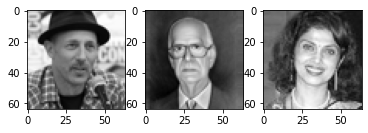

[0 0 1]


In [ ]:
indices = [0, 100, 10000]
show_images(train_x, image_size, indices)
print(train_y[indices])

In [ ]:
import copy

def remove_missing_value(train_data, test_data, value_threshold, threshold):
  x = copy.deepcopy(train_data)
  y = copy.deepcopy(test_data)

  x = (x < value_threshold).astype(int)
  x = np.sum(x, axis=1) / x.shape[1]
  x = x < threshold

  return train_data[x], test_data[x]

In [ ]:
train_x, train_y = remove_missing_value(train_x, train_y, 6, 0.95)

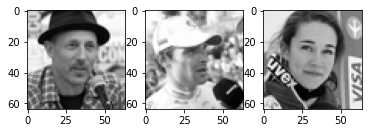

[0 0 1]


In [ ]:
show_images(train_x, image_size, indices)
print(train_y[indices])

In [ ]:
def shuffle_data(train_data, test_data):
  data_len = train_data.shape[0]
  indices = list(range(data_len))
  shuffle(indices)

  return train_data[indices, :], test_data[indices]

In [ ]:
train_x, train_y = shuffle_data(train_x, train_y)

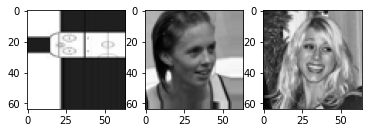

[0 1 1]


In [ ]:
show_images(train_x, image_size, indices)
print(train_y[indices])

In [ ]:
train_x = train_x / 255.
val_x = val_x / 255.

 Logistics Regression

In [ ]:
def sigmoid(z):
  return 1 / (1 + np.exp(-z))

In [ ]:
def logisitics_regression_fit(X, Y, num_iterations=500, learning_rate=0.05):
  X = X.T
  m = X.shape[1]

  w = np.zeros((X.shape[0], 1))
  b = 0

  for _ in range(num_iterations):
    A = sigmoid(np.dot(w.T, X) + b)
    cost = -1/m * (np.sum(Y * np.log(A) + (1 - Y) * np.log(1 - A)))
    cost = np.squeeze(cost)

    dw = 1/m * np.dot(X, (A - Y).T)
    db = 1/m * np.sum(A - Y)

    w = w - learning_rate * dw
    b = b - learning_rate * db

  return w, b, cost

In [ ]:
def logisitics_regression_predict(w, b, X):
  X = X.T
  m = X.shape[1]
  Y_pred = np.zeros(m).astype(int)
  w = w.reshape(X.shape[0], 1)

  A = sigmoid(np.dot(w.T, X)+ b)
  for i in range(A.shape[1]):
    Y_pred[i] = 1 if A[0, i] > 0.5 else 0
  
  return Y_pred

In [ ]:
w, b, cost = logisitics_regression_fit(train_x, train_y, num_iterations=200, learning_rate=0.005)

In [ ]:
pred = logisitics_regression_predict(w, b, val_x)

In [ ]:
print(f'Precision: {precision_score(val_y, pred)}')
print(f'Recall: {recall_score(val_y, pred)}')
print(f'f1 score: {f1_score(val_y, pred)}')
print(f'Accuracy: {accuracy_score(val_y, pred)}')

Precision: 0.813953488372093
Recall: 0.0277337559429477
f1 score: 0.05363984674329502
Accuracy: 0.7930630026809652


K Nearest Neighbour

In [ ]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(train_x, train_y)
pred = knn.predict(val_x)

In [ ]:
print(f'Precision: {precision_score(val_y, pred)}')
print(f'Recall: {recall_score(val_y, pred)}')
print(f'f1 score: {f1_score(val_y, pred)}')
print(f'Accuracy: {accuracy_score(val_y, pred)}')

Precision: 0.24713083397092578
Recall: 0.2559429477020602
f1 score: 0.2514597119501752
Accuracy: 0.6777815013404825


In [ ]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(train_x, train_y)
pred = knn.predict(val_x)

In [ ]:
print(f'Precision: {precision_score(val_y, pred)}')
print(f'Recall: {recall_score(val_y, pred)}')
print(f'f1 score: {f1_score(val_y, pred)}')
print(f'Accuracy: {accuracy_score(val_y, pred)}')

Precision: 0.5146726862302483
Recall: 0.18066561014263074
f1 score: 0.26744868035190617
Accuracy: 0.7907171581769437


In [ ]:
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(train_x, train_y)
pred = knn.predict(val_x)

In [ ]:
print(f'Precision: {precision_score(val_y, pred)}')
print(f'Recall: {recall_score(val_y, pred)}')
print(f'f1 score: {f1_score(val_y, pred)}')
print(f'Accuracy: {accuracy_score(val_y, pred)}')

Precision: 0.6074498567335244
Recall: 0.16798732171156894
f1 score: 0.2631905648665425
Accuracy: 0.8011058981233244


Nhận xét giữa Logistics Regression và K Nearest Neighbour:
- Về độ chính xác accuracy, hai model cho cùng kết quả xấp xỉ nhau.
- Về precision, Logistics Regression cho kết quả tốt hơn so với K Nearest Neighbour. Trong khi đó, K Nearest Neigbour chỉ đạt precision ở gần 0.5.
- Recall: Cả hai model đều không có điểm recall tốt, điểm recall của KNN cao hơn nhưng giá trị lại thấp, khoảng 0.2
F1 score: KNN có điểm F1 cao hơn so với Logistics Regressions, nhưng vẫn thấp ở mức 0.26.
